In [1]:
# Data Preparation and Graph Construction for Community Detection
# ===============================================================

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Optional imports for visualization
try:
    import plotly.graph_objects as go
    import plotly.express as px
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
except ImportError:
    PLOTLY_AVAILABLE = False
    
# For graph neural networks
try:
    import torch
    import torch_geometric
    from torch_geometric.data import Data
    TORCH_GEOMETRIC_AVAILABLE = True
except ImportError:
    TORCH_GEOMETRIC_AVAILABLE = False

# For community detection baselines
try:
    
    from cdlib import algorithms, evaluation
    CDLIB_AVAILABLE = True
except ImportError:
    CDLIB_AVAILABLE = False

from cdlib.classes import NodeClustering

Data Preparation and Graph Construction for Community Detection

1. Generating a synthetic Stochastic Block Model graph...
GRAPH STATISTICS
Number of nodes: 100
Number of edges: 491
Graph density: 0.0992
Average degree: 9.8200
Average clustering coefficient: 0.1485
Diameter: 4
Average shortest path length: 2.2808080808080806


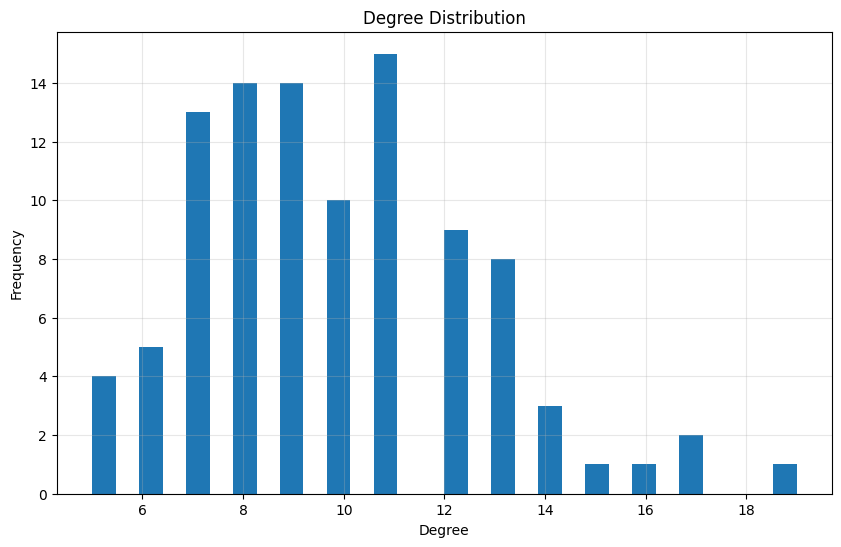

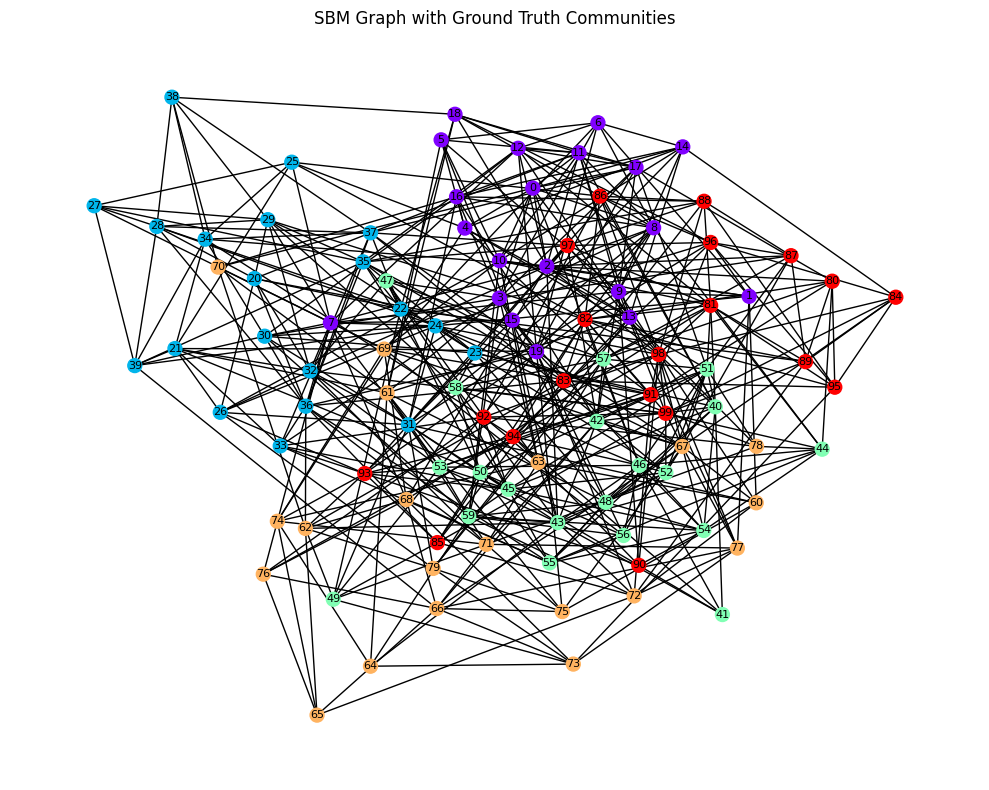


2. Working with real-world data would look like this...

3. Generating a Newman-Watts-Strogatz small-world network...
GRAPH STATISTICS
Number of nodes: 100
Number of edges: 223
Graph density: 0.0451
Average degree: 4.4600
Average clustering coefficient: 0.4200
Diameter: 9
Average shortest path length: 4.50080808080808


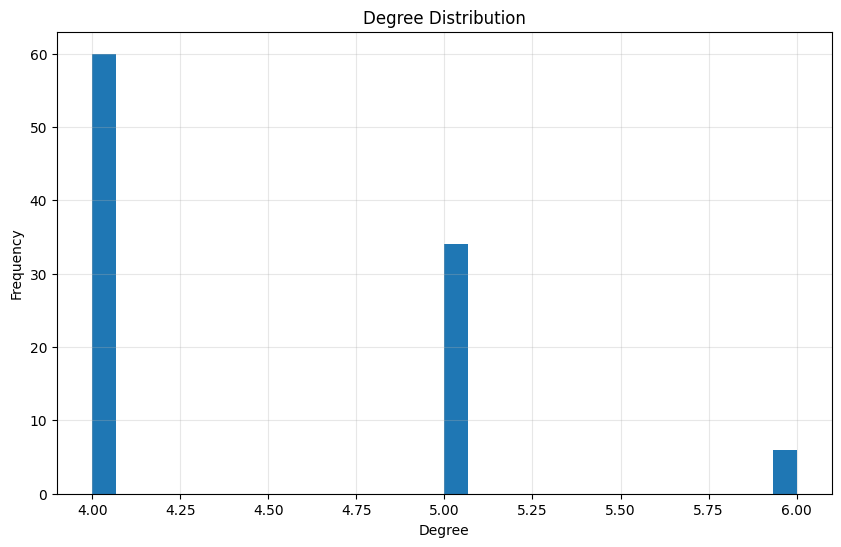

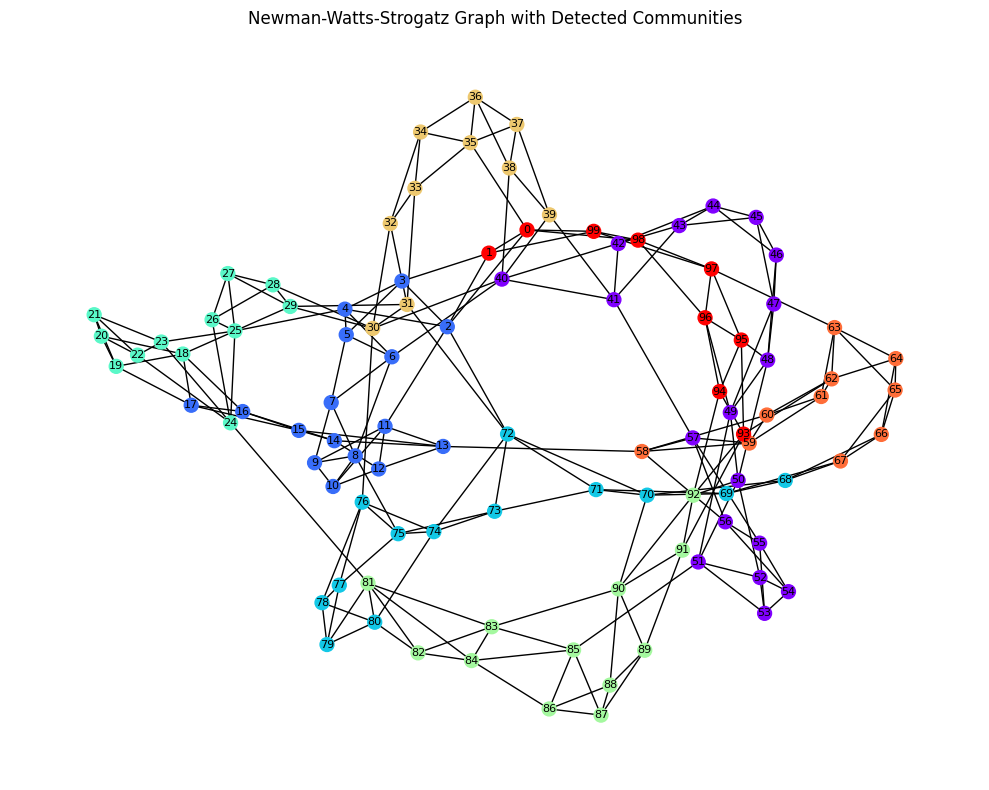


4. Running baseline community detection with Louvain algorithm...

Evaluating detected communities against ground truth...

Evaluation Metrics:
nmi: MatchingResult(score=np.float64(0.7974079934440323), std=None)
ari: MatchingResult(score=0.7731459899543679, std=None)
f1: MatchingResult(score=np.float64(0.898), std=np.float64(0.06462197768561406))


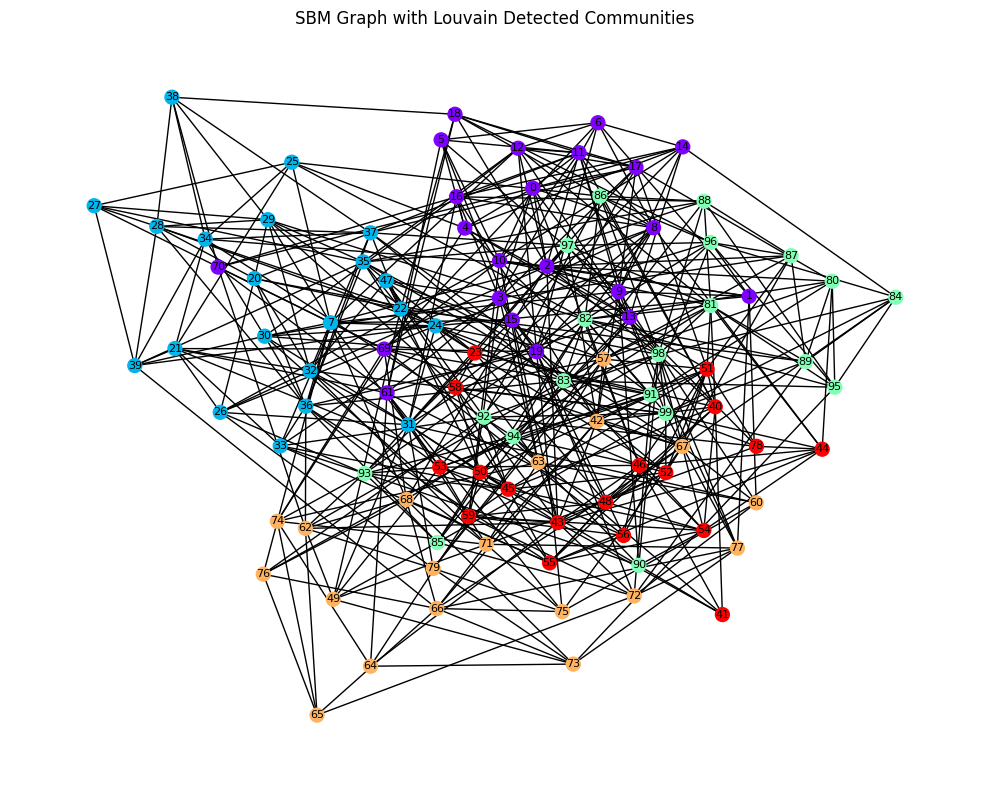


5. Converting to PyTorch Geometric format for GNN-based approaches...
PyTorch Geometric Data object created: Data(x=[100, 100], edge_index=[2, 491], y=[100])

Data preparation complete!


In [8]:
# Helper functions for data loading
def load_data(filepath, filetype='csv'):
    """
    Load data from various file formats
    
    Parameters:
    -----------
    filepath: str
        Path to the data file
    filetype: str
        Type of file (csv, json, pickle, etc.)
        
    Returns:
    --------
    data: DataFrame or dict
        Loaded data
    """
    if filetype.lower() == 'csv':
        return pd.read_csv(filepath)
    elif filetype.lower() == 'json':
        return pd.read_json(filepath)
    elif filetype.lower() == 'pickle':
        with open(filepath, 'rb') as f:
            return pickle.load(f)
    elif filetype.lower() == 'parquet':
        return pd.read_parquet(filepath)
    else:
        raise ValueError(f"Unsupported file type: {filetype}")


def create_graph_from_edgelist(edgelist, directed=False, weighted=False):
    """
    Create a NetworkX graph from an edge list
    
    Parameters:
    -----------
    edgelist: DataFrame
        DataFrame with edge information (source, target, [weight])
    directed: bool
        Whether the graph is directed
    weighted: bool
        Whether the graph has edge weights
        
    Returns:
    --------
    G: NetworkX Graph
        The constructed graph
    """
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
        
    if weighted:
        # Assuming edgelist has columns 'source', 'target', 'weight'
        for _, row in edgelist.iterrows():
            G.add_edge(row['source'], row['target'], weight=row['weight'])
    else:
        # Assuming edgelist has columns 'source', 'target'
        for _, row in edgelist.iterrows():
            G.add_edge(row['source'], row['target'])
    
    return G


def create_graph_from_adjacency(adjacency, node_features=None, node_labels=None):
    """
    Create a NetworkX graph from an adjacency matrix
    
    Parameters:
    -----------
    adjacency: numpy.ndarray
        Adjacency matrix
    node_features: numpy.ndarray
        Matrix of node features
    node_labels: numpy.ndarray
        Array of node labels (for ground truth communities)
        
    Returns:
    --------
    G: NetworkX Graph
        The constructed graph
    """
    G = nx.from_numpy_array(adjacency)
    
    # Add node features if provided
    if node_features is not None:
        for i, features in enumerate(node_features):
            G.nodes[i]['features'] = features
    
    # Add node labels (ground truth communities) if provided
    if node_labels is not None:
        for i, label in enumerate(node_labels):
            G.nodes[i]['community'] = label
            
    return G


def convert_nx_to_pytorch_geometric(G, node_features=None, node_labels=None):
    """
    Convert a NetworkX graph to a PyTorch Geometric Data object
    
    Parameters:
    -----------
    G: NetworkX Graph
        The graph to convert
    node_features: numpy.ndarray
        Matrix of node features (optional if already in G)
    node_labels: numpy.ndarray
        Array of node labels (optional if already in G)
        
    Returns:
    --------
    data: torch_geometric.data.Data
        PyTorch Geometric Data object
    """
    if not TORCH_GEOMETRIC_AVAILABLE:
        raise ImportError("PyTorch Geometric is not available")
    
    # Get edges
    edge_index = torch.tensor(list(G.edges)).t().contiguous()
    
    # Get node features
    if node_features is not None:
        x = torch.tensor(node_features, dtype=torch.float)
    elif 'features' in G.nodes[0]:
        x = torch.tensor([G.nodes[i]['features'] for i in range(len(G))], dtype=torch.float)
    else:
        # Use one-hot degree as default feature
        x = torch.zeros((len(G), len(G)))
        for i in range(len(G)):
            x[i, G.degree(i)] = 1
    
    # Get labels
    if node_labels is not None:
        y = torch.tensor(node_labels, dtype=torch.long)
    elif 'community' in G.nodes[0]:
        y = torch.tensor([G.nodes[i]['community'] for i in range(len(G))], dtype=torch.long)
    else:
        y = None
    
    # Create PyTorch Geometric Data object
    data = Data(x=x, edge_index=edge_index, y=y)
    
    return data


def plot_graph(G, community_attr=None, pos=None, figsize=(10, 8), title="Graph Visualization"):
    """
    Plot a NetworkX graph with community colors
    
    Parameters:
    -----------
    G: NetworkX Graph
        The graph to plot
    community_attr: str
        Node attribute name for community labels
    pos: dict
        Node positions for visualization
    figsize: tuple
        Figure size
    title: str
        Plot title
        
    Returns:
    --------
    None
    """
    plt.figure(figsize=figsize)
    
    if pos is None:
        pos = nx.spring_layout(G, seed=42)
    
    if community_attr is not None:
        communities = [G.nodes[node][community_attr] for node in G.nodes]
        cmap = plt.cm.rainbow
        nx.draw_networkx(G, pos=pos, node_color=communities, cmap=cmap, 
                         with_labels=True, node_size=100, font_size=8)
    else:
        nx.draw_networkx(G, pos=pos, with_labels=True, node_size=100, font_size=8)
    
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def generate_synthetic_graph(graph_type, n_nodes, n_communities=None, **kwargs):
    """
    Generate a synthetic graph with ground truth communities
    
    Parameters:
    -----------
    graph_type: str
        Type of graph ('sbm', 'nws', 'ba', 'lfr')
    n_nodes: int
        Number of nodes
    n_communities: int
        Number of communities
    **kwargs: 
        Additional parameters for specific graph models
        
    Returns:
    --------
    G: NetworkX Graph
        The synthetic graph
    ground_truth: list
        List of ground truth community assignments
    """
    if graph_type.lower() == 'sbm':  # Stochastic Block Model
        if n_communities is None:
            n_communities = 3
            
        # Example parameters
        sizes = [n_nodes // n_communities] * n_communities
        p_in = kwargs.get('p_in', 0.3)  # probability within community
        p_out = kwargs.get('p_out', 0.05)  # probability between communities
        
        # Create probability matrix
        p_matrix = np.ones((n_communities, n_communities)) * p_out
        np.fill_diagonal(p_matrix, p_in)
        
        G = nx.stochastic_block_model(sizes, p_matrix, seed=42)
        
        # Add ground truth
        ground_truth = []
        for i, size in enumerate(sizes):
            ground_truth.extend([i] * size)
            
        for i, comm in enumerate(ground_truth):
            G.nodes[i]['community'] = comm
            
    elif graph_type.lower() == 'nws':  # Newman-Watts-Strogatz
        k = kwargs.get('k', 5)  # Each node connected to k nearest neighbors
        p = kwargs.get('p', 0.1)  # Probability of rewiring
        
        G = nx.newman_watts_strogatz_graph(n_nodes, k, p, seed=42)
        
        # For NWS, we don't have inherent communities, so we'll use Louvain
        if CDLIB_AVAILABLE:
            communities = algorithms.louvain(G)
            ground_truth = communities.communities
            
            # Convert to node-indexed list
            node_to_comm = {}
            for i, comm in enumerate(ground_truth):
                for node in comm:
                    node_to_comm[node] = i
                    
            ground_truth = [node_to_comm[i] for i in range(n_nodes)]
            
            for i, comm in enumerate(ground_truth):
                G.nodes[i]['community'] = comm
        else:
            # Fallback if cdlib not available
            ground_truth = None
            
    elif graph_type.lower() == 'ba':  # Barabási-Albert
        m = kwargs.get('m', 3)  # Number of edges to attach from a new node
        
        G = nx.barabasi_albert_graph(n_nodes, m, seed=42)
        
        # For BA, we don't have inherent communities, so we'll use Louvain
        if CDLIB_AVAILABLE:
            communities = algorithms.louvain(G)
            ground_truth = communities.communities
            
            # Convert to node-indexed list
            node_to_comm = {}
            for i, comm in enumerate(ground_truth):
                for node in comm:
                    node_to_comm[node] = i
                    
            ground_truth = [node_to_comm[i] for i in range(n_nodes)]
            
            for i, comm in enumerate(ground_truth):
                G.nodes[i]['community'] = comm
        else:
            # Fallback if cdlib not available
            ground_truth = None
            
    elif graph_type.lower() == 'lfr':  # Lancichinetti-Fortunato-Radicchi benchmark
        if not CDLIB_AVAILABLE:
            raise ImportError("cdlib is required for LFR benchmark")
            
        tau1 = kwargs.get('tau1', 3)  # Power law exponent for degree distribution
        tau2 = kwargs.get('tau2', 1.5)  # Power law exponent for community size distribution
        mu = kwargs.get('mu', 0.1)  # Mixing parameter
        
        # Use cdlib to generate LFR benchmark
        G, ground_truth = algorithms.lfr_benchmark(
            n=n_nodes,
            tau1=tau1,
            tau2=tau2,
            mu=mu,
            average_degree=kwargs.get('avg_degree', 10),
            min_degree=kwargs.get('min_degree', 5),
            max_degree=kwargs.get('max_degree', 50),
            min_community=kwargs.get('min_community', 20),
            max_community=kwargs.get('max_community', 100),
            seed=42
        )
        
        # Add ground truth to nodes
        for i, comm in enumerate(ground_truth):
            G.nodes[i]['community'] = comm
    else:
        raise ValueError(f"Unsupported graph type: {graph_type}")
        
    return G, ground_truth


def compute_graph_statistics(G):
    """
    Compute various statistics for a graph
    
    Parameters:
    -----------
    G: NetworkX Graph
        The graph to analyze
        
    Returns:
    --------
    stats: dict
        Dictionary of graph statistics
    """
    stats = {}
    
    stats['n_nodes'] = G.number_of_nodes()
    stats['n_edges'] = G.number_of_edges()
    stats['density'] = nx.density(G)
    stats['avg_degree'] = sum(dict(G.degree()).values()) / G.number_of_nodes()
    stats['avg_clustering'] = nx.average_clustering(G)
    
    try:
        # These can be computationally expensive for large graphs
        stats['diameter'] = nx.diameter(G)
        stats['avg_shortest_path'] = nx.average_shortest_path_length(G)
    except:
        stats['diameter'] = 'N/A (Graph may be disconnected)'
        stats['avg_shortest_path'] = 'N/A (Graph may be disconnected)'
    
    # Degree distribution
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    stats['degree_distribution'] = degree_sequence
    
    return stats


def display_graph_statistics(stats):
    """
    Print graph statistics in a readable format
    
    Parameters:
    -----------
    stats: dict
        Dictionary of graph statistics
        
    Returns:
    --------
    None
    """
    print("=" * 50)
    print("GRAPH STATISTICS")
    print("=" * 50)
    print(f"Number of nodes: {stats['n_nodes']}")
    print(f"Number of edges: {stats['n_edges']}")
    print(f"Graph density: {stats['density']:.4f}")
    print(f"Average degree: {stats['avg_degree']:.4f}")
    print(f"Average clustering coefficient: {stats['avg_clustering']:.4f}")
    print(f"Diameter: {stats['diameter']}")
    print(f"Average shortest path length: {stats['avg_shortest_path']}")
    print("=" * 50)
    
    # Plot degree distribution
    plt.figure(figsize=(10, 6))
    plt.hist(stats['degree_distribution'], bins=30)
    plt.title('Degree Distribution')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.show()


def detect_communities_baseline(G, method='louvain'):
    """
    Detect communities using traditional methods
    
    Parameters:
    -----------
    G: NetworkX Graph
        The graph to analyze
    method: str
        Community detection method ('louvain', 'leiden', 'infomap', etc.)
        
    Returns:
    --------
    communities: list of lists
        Detected communities
    """
    if not CDLIB_AVAILABLE:
        raise ImportError("cdlib is required for community detection")
    
    if method.lower() == 'louvain':
        result = algorithms.louvain(G)
    elif method.lower() == 'leiden':
        result = algorithms.leiden(G)
    elif method.lower() == 'infomap':
        result = algorithms.infomap(G)
    elif method.lower() == 'greedy_modularity':
        result = algorithms.greedy_modularity(G)
    elif method.lower() == 'label_propagation':
        result = algorithms.label_propagation(G)
    else:
        raise ValueError(f"Unsupported method: {method}")
    
    return result.communities


def evaluate_communities(G, detected_communities, ground_truth_attr=None):
    """
    Evaluate detected communities against ground truth
    
    Parameters:
    -----------
    G: NetworkX Graph
        The graph with community information
    detected_communities: list of lists
        List of detected communities
    ground_truth_attr: str
        Node attribute name for ground truth community
        
    Returns:
    --------
    metrics: dict
        Dictionary of evaluation metrics
    """
    if not CDLIB_AVAILABLE:
        raise ImportError("cdlib is required for community evaluation")
    
    # Convert detected communities to cdlib format
    detected = NodeClustering(
        detected_communities, 
        graph=G
    )
    
    # Get ground truth communities if attribute is provided
    if ground_truth_attr is not None:
        ground_truth = []
        labels = nx.get_node_attributes(G, ground_truth_attr)
        
        # Group nodes by community label
        community_to_nodes = {}
        for node, comm in labels.items():
            if comm not in community_to_nodes:
                community_to_nodes[comm] = []
            community_to_nodes[comm].append(node)
        
        ground_truth = list(community_to_nodes.values())
        
        # Convert to cdlib format
        ground_truth = NodeClustering(
            ground_truth,
            graph=G
        )
        
        # Calculate metrics
        metrics = {}
        metrics['nmi'] = evaluation.normalized_mutual_information(detected, ground_truth)
        metrics['ari'] = evaluation.adjusted_rand_index(detected, ground_truth)
        metrics['f1'] = evaluation.f1(detected, ground_truth)
    else:
        # Calculate metrics without ground truth
        metrics = {}
        metrics['modularity'] = evaluation.newman_girvan_modularity(detected).score
        metrics['conductance'] = evaluation.conductance(detected).score
        metrics['internal_edge_density'] = evaluation.internal_edge_density(detected).score
    
    return metrics


# Main execution example - will adapt based on actual data
if __name__ == "__main__":
    print("Data Preparation and Graph Construction for Community Detection")
    print("="*70)
    
    # Example 1: Generate a synthetic graph
    print("\n1. Generating a synthetic Stochastic Block Model graph...")
    G_sbm, ground_truth_sbm = generate_synthetic_graph('sbm', n_nodes=100, n_communities=5, 
                                                      p_in=0.3, p_out=0.05)
    
    # Compute and display statistics
    stats_sbm = compute_graph_statistics(G_sbm)
    display_graph_statistics(stats_sbm)
    
    # Visualize the graph with ground truth communities
    plot_graph(G_sbm, community_attr='community', title="SBM Graph with Ground Truth Communities")
    
    # Example 2: Load a real-world dataset (replace with actual data path)
    print("\n2. Working with real-world data would look like this...")
    # data = load_data("path/to/your/data.csv")
    # edgelist = data[['source', 'target', 'weight']]
    # G_real = create_graph_from_edgelist(edgelist, weighted=True)
    
    # Example 3: Newman-Watts-Strogatz small-world network
    print("\n3. Generating a Newman-Watts-Strogatz small-world network...")
    G_nws, ground_truth_nws = generate_synthetic_graph('nws', n_nodes=100, k=5, p=0.1)
    
    # Compute and display statistics
    stats_nws = compute_graph_statistics(G_nws)
    display_graph_statistics(stats_nws)
    
    # Visualize the graph with detected communities
    if ground_truth_nws:
        plot_graph(G_nws, community_attr='community', 
                  title="Newman-Watts-Strogatz Graph with Detected Communities")
    
    # Example 4: Compare a baseline community detection method with ground truth
    if CDLIB_AVAILABLE:
        print("\n4. Running baseline community detection with Louvain algorithm...")
        detected_communities = detect_communities_baseline(G_sbm, method='louvain')
        
        # Convert detected communities to node-indexed format for visualization
        node_to_comm = {}
        for i, comm in enumerate(detected_communities):
            for node in comm:
                node_to_comm[node] = i
                
        # Add detected communities as a node attribute
        for node in G_sbm.nodes():
            if node in node_to_comm:
                G_sbm.nodes[node]['detected'] = node_to_comm[node]
        
        # Evaluate against ground truth
        print("\nEvaluating detected communities against ground truth...")
        metrics = evaluate_communities(G_sbm, detected_communities, ground_truth_attr='community')
        print("\nEvaluation Metrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value}")
        
        # Visualize detected communities
        plot_graph(G_sbm, community_attr='detected', 
                  title="SBM Graph with Louvain Detected Communities")
    
    # Example 5: Convert to PyTorch Geometric format for GNN-based approaches
    if TORCH_GEOMETRIC_AVAILABLE:
        print("\n5. Converting to PyTorch Geometric format for GNN-based approaches...")
        data = convert_nx_to_pytorch_geometric(G_sbm)
        print(f"PyTorch Geometric Data object created: {data}")
        
    print("\nData preparation complete!")